In [1]:
from main import get_transforms
from models import save_network
import math
from train import gen_input, rand_between, gen_input_rand,get_coor

import torch
import torch.nn as nn

from models import scribbler, discriminator, texturegan, localDiscriminator
import torch.optim as optim
from torch.autograd import Variable

import sys, os
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import visdom
from IPython.display import display
import torchvision.models as models
from dataloader import imfol
from torch.utils.data.sampler import SequentialSampler

from torch.utils.data import DataLoader
#from dataloader.imfol import ImageFolder

from utils import transforms as custom_transforms
from utils.visualize import vis_patch, vis_image
from models import scribbler, discriminator, define_G, weights_init, scribbler_dilate_128
import argparser

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

GPU_ID = 2

In [2]:
import torch.utils.data as data

from PIL import Image
import glob
import os
import os.path as osp
import random
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def find_classes(directory):
    classes = [d for d in os.listdir(directory) if osp.isdir(os.path.join(directory, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(directory, opt, erode_seg=True):
    # opt: 'train' or 'val'
    img = glob.glob(osp.join(directory, opt + '_img/*/*.jpg'))
    img = sorted(img)
    skg = glob.glob(osp.join(directory, opt + '_skg/*/*.jpg'))
    skg = sorted(skg)
    seg = glob.glob(osp.join(directory, opt + '_seg/*/*.jpg'))
    seg = sorted(seg)
    txt = glob.glob(osp.join(directory, 'train_txt_leather/*/*.jpg'))
    #txt = glob.glob(osp.join(directory, opt + '_txt/*/*.jpg'))
    extended_txt = []
    #import pdb; pdb.set_trace()
    for i in range(len(skg)):
        extended_txt.append(txt[i%len(txt)])
    random.shuffle(extended_txt)

    if erode_seg:
        eroded_seg = glob.glob(osp.join(directory, 'eroded_' + opt + '_seg/*/*.jpg'))
        eroded_seg = sorted(eroded_seg)
        return list(zip(img, skg, seg , eroded_seg, extended_txt))
    else:
        return list(zip(img, skg, seg, extended_txt))


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    return pil_loader(path)


    
class ImageFolder(data.Dataset):
    def __init__(self, opt, root, transform=None, target_transform=None,
                 loader=default_loader, erode_seg=True):
     
        self.root = root
        self.imgs = make_dataset(root, opt, erode_seg=erode_seg)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.erode_seg = erode_seg

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """

        if self.erode_seg:
            img_path, skg_path, seg_path, eroded_seg_path, txt_path = self.imgs[index]
        else:
            img_path, skg_path, seg_path, txt_path = self.imgs[index]
        
        img = self.loader(img_path)
        skg = self.loader(skg_path)
        seg = self.loader(seg_path)
        txt = self.loader(txt_path)

        if self.erode_seg:
            eroded_seg = self.loader(eroded_seg_path)
        else:
            eroded_seg = None

        if self.transform is not None:
            if self.erode_seg:
                img, skg, seg, eroded_seg, txt = self.transform([img, skg, seg, eroded_seg, txt])
            else:
                img, skg, seg, txt = self.transform([img, skg, seg, txt])
                eroded_seg = seg

        return img, skg, seg, eroded_seg, txt


    def __len__(self):
        return len(self.imgs)

In [8]:
import argparse

def parse_arguments(argv):
    parser = argparse.ArgumentParser()

    parser.add_argument('-lr', '--learning_rate', default=1e-3, type=float,
                        help='Learning rate for the generator')
    parser.add_argument('-lrd', '--learning_rate_D', default=1e-4, type=float,
                        help='Learning rate for the discriminator')
    parser.add_argument('-lrd_l', '--learning_rate_D_local', default=1e-4, type=float,
                        help='Learning rate for the discriminator')

    parser.add_argument('--gan', default='lsgan', type=str, choices=['dcgan', 'lsgan', 'wgan', 'improved wgan'],
                        help='dcgan|lsgan|wgan|improved wgan')  # todo wgan/improved wgan

    parser.add_argument('--model', default='scribbler', type=str, choices=['scribbler', 'texturegan', 'pix2pix','scribbler_dilate_128'],
                        help='scribbler|pix2pix')

    parser.add_argument('--num_epoch', default=100, type=int,
                        help='texture|scribbler')

    parser.add_argument('--visualize_every', default=10, type=int,
                        help='no. iteration to visualize the results')

    # all the weights ratio, might wanna make them sum to one
    parser.add_argument('--feature_weight', default=0, type=float,
                        help='weight ratio for feature loss')
    parser.add_argument('--global_pixel_weight_l', default=0, type=float,
                        help='weight ratio for pixel loss for l channel')
    parser.add_argument('--local_pixel_weight_l', default=1,  type=float,
                        help='pixel weight for local loss patch')
    parser.add_argument('--pixel_weight_ab', default=0, type=float,
                        help='weight ratio for pixel loss for ab channel')
    parser.add_argument('--pixel_weight_rgb', default=0, type=float,
                        help='weight ratio for pixel loss for ab channel')

    parser.add_argument('--discriminator_weight', default=0, type=float,
                        help='weight ratio for the discriminator loss')
    parser.add_argument('--discriminator_local_weight', default=0, type=float,
                        help='weight ratio for the discriminator loss')
    parser.add_argument('--style_weight', default=0, type=float,
                        help='weight ratio for the texture loss')

    parser.add_argument('--gpu', default=2, type=int, help="GPU ID")

    parser.add_argument('--display_port', default=7779, type=int,
                        help='port for displaying on visdom (need to match with visdom currently open port)')

    parser.add_argument('--data_path', default='/home/psangkloy3/training_handbags_pretrain/', type=str,
                        help='path to the data directory, expect train_skg, train_img, val_skg, val_img')

    parser.add_argument('--save_dir', default='/home/psangkloy3/test/', type=str,
                        help='path to save the model')

    parser.add_argument('--load_dir', default='/home/psangkloy3/test/', type=str,
                        help='path to save the model')

    parser.add_argument('--save_every', default=1000, type=int,
                        help='no. iteration to save the models')

    parser.add_argument('--load_epoch', default=-1, type=int,
                        help="The epoch number for the model to load")
    parser.add_argument('--load', default=-1, type=int,
                        help='load generator and discrminator from iteration n')
    parser.add_argument('--load_D', default=-1, type=int,
                        help='load discriminator from iteration n, priority over load')

    parser.add_argument('--image_size', default=152, type=int,
                        help='Training images size, after cropping')
    parser.add_argument('--resize_to', default=300, type=int,
                        help='Training images size, after cropping')
                        
    parser.add_argument('--resize_max', default=1, type=float,
                        help='max resize, ratio of the original image, max value is 1')
    parser.add_argument('--resize_min', default=0.6, type=float,
                        help='min resize, ratio of the original image, min value 0')
    parser.add_argument('--patch_size_min', default=20, type=int,
                        help='minumum texture patch size')
    parser.add_argument('--patch_size_max', default=40, type=int,
                        help='max texture patch size')

    parser.add_argument('--batch_size', default=32, type=int, help="Training batch size. MUST BE EVEN NUMBER")

    parser.add_argument('--num_input_texture_patch', default=2,type=int)
    parser.add_argument('--num_local_texture_patch', default=1,type=int)

    parser.add_argument('--color_space', default='lab', type=str, choices=['lab', 'rgb'],
                        help='lab|rgb')

    parser.add_argument('--threshold_D_max', default=0.8, type=int,
                        help='stop updating D when accuracy is over max')

    parser.add_argument('--content_layers', default='relu4_2', type=str,
                        help='Layer to attach content loss.')
    parser.add_argument('--style_layers', default='relu3_2, relu4_2', type=str,
                        help='Layer to attach content loss.')

    parser.add_argument('--use_segmentation_patch', default=True, type=bool,
                        help='whether or not to inject noise into the network')

    parser.add_argument('--input_texture_patch', default='dtd_texture', type=str,
                        choices=['original_image', 'dtd_texture'],
                        help='whether or not to inject noise into the network')
    
    parser.add_argument('--loss_texture', default='dtd_texture', type=str,
                        choices=['original_image', 'dtd_texture'],
                        help='where is the texture loss come from')
    
    parser.add_argument('--local_texture_size', default=50, type=int,
                        help='use local texture loss instead of global, set -1 to use global')
    
    parser.add_argument('--texture_discrminator_loss', default=True, type=bool,
                        help='adding discrminator for texture')
    
    return parser.parse_args(argv)
command = '--display_port 7770 --load 0 --load_D -1 --load_epoch 105 --gpu 2 --model texturegan --feature_weight 1e2 --pixel_weight_ab 1e3 --global_pixel_weight_l 1e3 --local_pixel_weight_l 0 --style_weight 0 --discriminator_weight 1e3 --discriminator_local_weight 1e6  --learning_rate 1e-4 --learning_rate_D 1e-4 --batch_size 36 --save_every 50 --num_epoch 100000 --save_dir /home/psangkloy3/skip_leather_re/ --load_dir /home/psangkloy3/skip_leather_re/ --data_path ../training_handbags_pretrain/ --learning_rate_D_local  1e-4 --local_texture_size 50 --patch_size_min 20 --patch_size_max 40 --num_input_texture_patch 1 --visualize_every 5 --num_local_texture_patch 1'
args = parse_arguments(command.split())


In [9]:
def get_input(val_loader,xcenter,ycenter,patch_size,num_patch):
    img, skg, seg, eroded_seg, txt = val_loader
    img = custom_transforms.normalize_lab(img)
    skg = custom_transforms.normalize_lab(skg)
    txt = custom_transforms.normalize_lab(txt)
    seg = custom_transforms.normalize_seg(seg)
    eroded_seg = custom_transforms.normalize_seg(eroded_seg)

    bs, w, h = seg.size()

    seg = seg.view(bs, 1, w, h)
    seg = torch.cat((seg, seg, seg), 1)

    eroded_seg = eroded_seg.view(bs, 1, w, h)
    eroded_seg = torch.cat((eroded_seg, eroded_seg, eroded_seg), 1)

    temp = torch.ones(seg.size()) * (1 - seg).float()
    temp[:, 1, :, :] = 0  # torch.ones(seg[:,1,:,:].size())*(1-seg[:,1,:,:]).float()
    temp[:, 2, :, :] = 0  # torch.ones(seg[:,2,:,:].size())*(1-seg[:,2,:,:]).float()

    txt = txt.float() * seg.float() + temp

    patchsize = args.local_texture_size
    batch_size = bs
    if xcenter < 0 or ycenter < 0:
        inp, texture_loc = gen_input_rand(txt, skg, eroded_seg[:, 0, :, :] * 100,
                                              patch_size, patch_size,
                                              num_patch)
    else:
        inp, texture_loc = gen_input_exact(txt, skg, eroded_seg[:, 0, :, :] * 100,xcenter,ycenter,patch_size,1)
        
    return inp,texture_loc    
def get_inputv(inp):
    input_stack = torch.FloatTensor().cuda()
    input_stack.resize_as_(inp.float()).copy_(inp)
    inputv = Variable(input_stack)
    return inputv

def gen_input_exact(img, skg, seg, xcenter=64, ycenter=64, crop_size=60, num_patch=1):
    #generate input skg with random patch from img
    #input img,skg [bsx3xwxh], xcenter,ycenter, size 
    #output bsx5xwxh
    MAX_COUNT = 10000
    bs,c,w,h = img.size()
    results = torch.Tensor(bs,5,w,h)
    texture_info = []

    #text_info.append([xcenter,ycenter,crop_size])    
    seg = seg/torch.max(seg)
    counter = 0
    for i in range(bs):
        counter=0
        ini_texture = torch.ones(img[0].size())*(1)
        ini_mask =  torch.ones((1,w,h))*(-1)
        temp_info = []
        for j in range(num_patch):
            xstart = max(int(xcenter-crop_size/2), 0)
            ystart = max(int(ycenter-crop_size/2), 0)
            xend = min(int(xcenter + crop_size/2), w)
            yend = min(int(ycenter + crop_size/2), h)
            patch = seg[i, xstart:xend, ystart:yend]
            sizem = torch.ones(patch.size())            

            temp_info.append([xcenter, ycenter, crop_size])
            res = gen_input(img[i], skg[i], ini_texture, ini_mask, xcenter, ycenter, crop_size)
          
            ini_texture = res[1:4,:,:]
            
        texture_info.append(temp_info)
        results[i,:,:,:] = res
    return results, texture_info
def get_G(location):
    net = texturegan.TextureGAN(5, 3, 32).cuda(GPU_ID)
    load_network(net, location)
    
    return net

def load_network(model, location):
    model_state = torch.load(location)
    
    model.load_state_dict(model_state["state_dict"])

In [10]:
def make_dataset(directory, opt, erode_seg=True):
    # opt: 'train' or 'val'
    img = glob.glob(osp.join(directory, opt + '_img/*/*.jpg'))
    img = sorted(img)
    skg = glob.glob(osp.join(directory, opt + '_skg/*/*.jpg'))
    skg = sorted(skg)
    seg = glob.glob(osp.join(directory, opt + '_seg/*/*.jpg'))
    seg = sorted(seg)
    txt = glob.glob(osp.join('../training_handbags_pretrain/', 'train_txt_dtd/*/*.jpg'))
    #txt = glob.glob(osp.join('../../training_handbags_pretrain/', 'train_txt_stripe/*/*.jpg'))
    #txt = glob.glob(osp.join(directory, opt + '_txt/*/*.jpg'))
    extended_txt = []
    #import pdb; pdb.set_trace()
    for i in range(len(skg)):
        extended_txt.append(txt[i%len(txt)])
    random.shuffle(extended_txt)

    if erode_seg:
        eroded_seg = glob.glob(osp.join(directory, 'eroded_' + opt + '_seg/*/*.jpg'))
        eroded_seg = sorted(eroded_seg)
        return list(zip(img, skg, seg , eroded_seg, extended_txt))
    else:
        return list(zip(img, skg, seg, extended_txt))

In [15]:
with torch.cuda.device(GPU_ID):
    color_space = 'lab'
    model_locs = [
                  
                  "../skipconnection_handbag/G_net_texturegan_45_0.pth",
                    "../skip_leather_handbag_222/G_net_texturegan_222_300.pth",
                  #"../../skip_leather/G_net_texturegan_105_1450.pth",
                #"../../skip_stripe_perforate/G_net_texturegan_142_0.pth",
                 ]
    models = []
    for model_loc in model_locs:
        model = get_G(model_loc).cuda()
        models.append(model.eval())
    
    transform = get_transforms(args)
    val = make_dataset(args.data_path, 'val')
    valDset = ImageFolder('val', args.data_path, transform)
    val_display_size = 1
    indices = torch.randperm(len(valDset))
    val_display_sampler = SequentialSampler(indices[:val_display_size])
    valLoader = DataLoader(dataset=valDset, batch_size=val_display_size,shuffle=True)
    


0


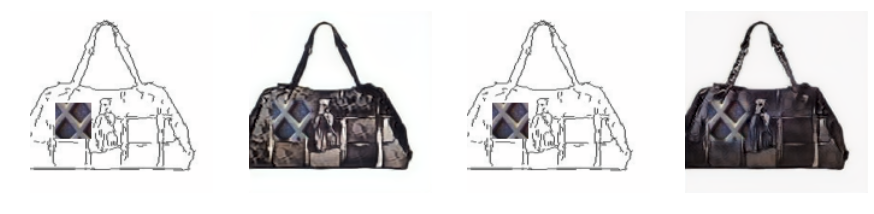

1


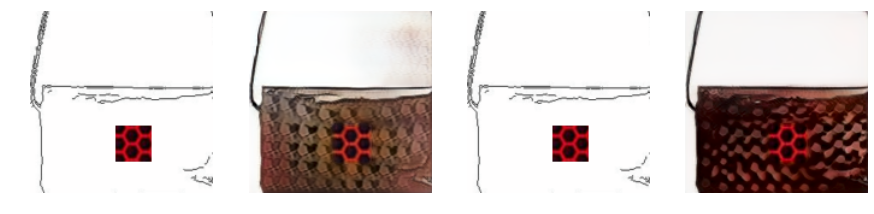

2


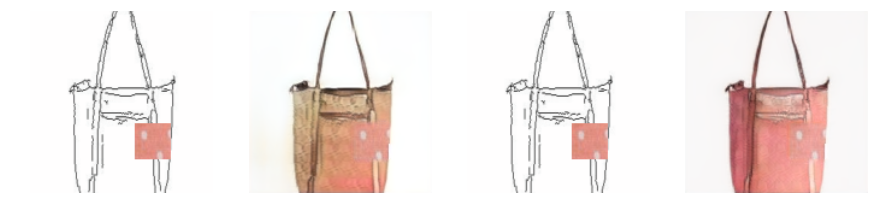

3


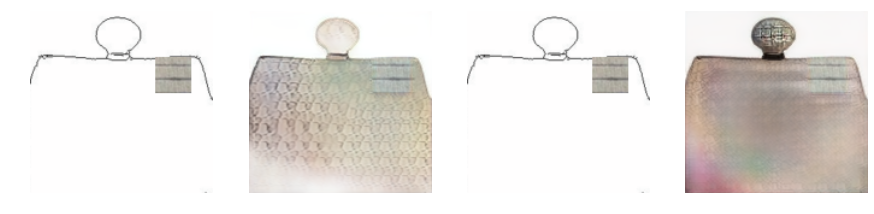

4


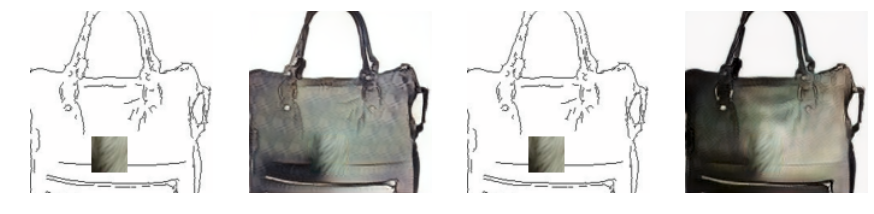

5


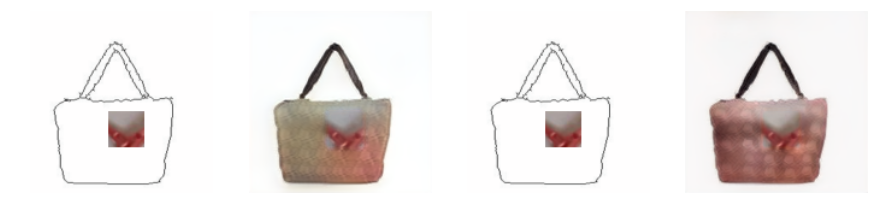

In [18]:
MAX = 5
count = 0
results = []
datas = []
with torch.cuda.device(GPU_ID):    
    for data in valLoader:
    #if True:
        if count> MAX:
            break
        count = count + 1
        #data = valLoader.__iter__().__next__()
        datas.append(data)
        img, skg, seg, eroded_seg, txt = data
        img = custom_transforms.normalize_lab(img)
        skg = custom_transforms.normalize_lab(skg)
        txt = custom_transforms.normalize_lab(txt)
        seg = custom_transforms.normalize_seg(seg)
        eroded_seg = custom_transforms.normalize_seg(eroded_seg)
        inp,texture_loc = get_input(data,-1,-1,30,1)
        
        
            #print inpv.size()
            #print model[0]
        plt.figure(figsize=(15, 8))
        num_model = len(models)
        print count-1
        temp_results = []
        for i,model in enumerate(models):
            
            inpv = get_inputv(inp.cuda())
            output = model(inpv.cuda())

            out_img = vis_image(custom_transforms.denormalize_lab(output.data.double().cpu()),
                                    color_space)
            inp_img = vis_patch(custom_transforms.denormalize_lab(txt.cpu()),
                                        custom_transforms.denormalize_lab(skg.cpu()),
                                        texture_loc,
                                        color_space)
            tar_img = vis_image(custom_transforms.denormalize_lab(img.cpu()),
                                    color_space)
            #for ii in range(num_model):
            plt.subplot('1'+str(2*num_model)+str(2*i+1))
            plt.imshow(np.transpose(inp_img[0],(1, 2, 0)))
            plt.axis('off')
        #plt.figure()  
            plt.subplot('1'+str(2*num_model)+str(2*i+2))
            plt.imshow(np.transpose(out_img[0],(1, 2, 0)))
            plt.axis('off')
            temp_results.append([np.transpose(inp_img[0],(1, 2, 0)),np.transpose(out_img[0],(1, 2, 0))])
        results.append(temp_results)
            
        plt.show()